# Import

In [1]:
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

SEED = 42

In [2]:
def line_plot(y_test, y_pred, plot_value, plot_name=None):

    plot_data = [('white', 'red', ''), ('white', 'black', '_colored')]
    for color, marker_color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create separate figures
        sns.lineplot(y_test, label='Истинные данные', color=color, marker='o', markersize=5, markerfacecolor=marker_color)
        sns.lineplot(y_pred, label='Предсказанные данные')  # Simplified
        plt.xlim(0, plot_value)
        plt.ylim(0, round(max(y_test)))
        plt.xlabel('Количество данных', fontsize=12)
        plt.ylabel('Значение данных', fontsize=12)
        plt.grid(alpha=0.5, color='black')
        plt.legend(loc=8) # Add a legend to distinguish lines

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")


def scatter_plot(y_test, y_pred, lim_value, plot_name=None):
    """Creates two separate scatter plots, optimized for efficiency."""
    plot_data = [(None, ''), ('grey', '_colored')]  # Store plot parameters
    for color, suffix in plot_data:
        plt.figure(figsize=(8, 4))  # Create new figure for each plot
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color=color)  # Use color directly
        sns.lineplot(x=[0, lim_value], y=[0, lim_value], color='black')
        plt.xlim(0, lim_value)
        plt.ylim(0, lim_value)
        plt.xlabel('Истинные значения', fontsize=12)
        plt.ylabel('Предсказанные значения', fontsize=12)
        plt.grid(alpha=0.5, color='black')

        filename = f'{plot_name}{suffix}.pdf' if plot_name else None
        if filename:
            plt.savefig(f'{filename}', bbox_inches="tight")

def reccur_potok(alpha, beta):
    return random.lognormvariate(alpha, beta)


def gen_recurr(row, col, y_pred1, y_pred2):
    time_list = np.zeros((row, col)) # Use numpy array directly
    alpha_list = y_pred1 # Vectorized alpha and beta extraction
    beta_list = y_pred2

    for i in range(row):
        time = 0
        for j in range(col):
            time += reccur_potok(abs(alpha_list[i]), abs(beta_list[i])) # Use pre-calculated alpha and beta
            time_list[i, j] = time # Use numpy indexing

    df_prov = pd.DataFrame(time_list)
    df_prov['alpha_value'] = alpha_list
    df_prov['beta_value'] = beta_list
    return df_prov

def print_curve_metrics(X_test_interval, df_prov_interval, itog_itog_list):
    relative_error_mean_list = []
    relative_error_std_list = []
    for i in range(X_test_interval.shape[0]):
        relative_error_mean_list.append(abs(X_test_interval.iloc[i].mean() - df_prov_interval.iloc[i].mean()) / X_test_interval.iloc[i].mean())
        relative_error_std_list.append(abs(X_test_interval.iloc[i].std() - df_prov_interval.iloc[i].std()) / X_test_interval.iloc[i].std())

    abs_list = []
    abs_itog_list = itog_itog_list
    for i in range(X_test_interval.shape[0]):
        for j in range(X_test_interval.shape[1]):
            abs_itog_list[i][j] = abs(itog_itog_list[i][j])
        abs_list.append(max(itog_itog_list[i]))

    metrics_df = pd.DataFrame({
        'relative_error_mean': relative_error_mean_list,
        'relative_error_std': relative_error_std_list,
        'abs_list': abs_list
    })
    
    # Вычисление средних и медианных значений
    test_result_mean = {
        'relative_error_mean_mean': metrics_df['relative_error_mean'].mean(),
        'relative_error_mean_median': metrics_df['relative_error_mean'].median(),
        'relative_error_std_mean': metrics_df['relative_error_std'].mean(),
        'relative_error_std_median': metrics_df['relative_error_std'].median(),
        'abs_mean': metrics_df['abs_list'].mean(),
        'abs_median': metrics_df['abs_list'].median()
    }

    metrics_mean_df = pd.DataFrame([test_result_mean])

    # Вывод результатов
    for key, value in test_result_mean.items():
        print(f'{key}:\t{value:.3f}')
        
    return 


def evaluate_regression(y_true, y_pred, param_name):
    """Evaluates regression performance."""

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{param_name}")
    print(f'MAE: {mae:.3f}')
    print(f'MSE: {mse:.3f}')
    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R² Score: {r2:.3f}')
    return # No need to explicitly return None

def get_intervals_from_df(df):
    intervals = df.diff(axis=1).iloc[:, 1:]
    intervals.columns = range(intervals.shape[1])
    return intervals

def calculate_statistics(X):
    """Вычисляет статистические характеристики для матрицы наблюдений X."""

    n_observations = X.shape[0]
    stat_M = np.zeros((n_observations, 10))

    # Векторизованные вычисления для основных статистик
    stat_M[:, 0] = np.mean(X, axis=1)
    stat_M[:, 1] = np.var(X, axis=1)
    stat_M[:, 2] = np.std(X, axis=1)
    stat_M[:, 3] = stat_M[:, 2] / stat_M[:, 0]  # Коэффициент вариации

    # Квантили. Избегаем повторного вычисления квантилей
    quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
    quantiles_values = np.quantile(X, quantiles, axis=1)
    stat_M[:, 4:10] = quantiles_values.T # Транспонируем, чтобы правильно разместить

    return stat_M

# Read and split

In [3]:
df = pd.read_csv("/home/jupyter/datasphere/datasets/datasets/lognorm.csv", sep=",", index_col=0)

In [4]:
df.shape

(10000, 10003)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,mu,sigma,lmbd
0,0.267854,7.344241,7.715817,7.916727,8.212631,8.526321,56.373440,57.835929,62.701109,90.908387,90.988061,104.864162,105.058653,105.084134,105.293650,105.556805,106.371983,106.377076,106.405224,109.748997,110.227769,110.310864,121.249569,121.510777,121.518139,124.034618,124.035149,124.192348,128.561255,130.305257,130.310016,130.531921,130.983693,132.954656,132.964709,133.210345,167.183595,171.259238,171.380602,171.931949,...,88463.542193,88465.836526,88468.775851,88469.863891,88470.088316,88472.057081,88472.082357,88492.986344,88493.013346,88493.954344,88495.456928,88495.896523,88496.211971,88521.808205,88522.820226,88523.628212,88523.645816,88530.987301,88531.351178,88531.453216,88532.752087,88533.705939,88533.980436,88536.745395,88537.085934,88537.338266,88537.975234,88539.602233,88540.839602,88540.897582,88541.015672,88541.060429,88541.167806,88546.385102,88546.391878,88546.445662,88551.092849,-0.510891,2.321259,0.522182
1,1.193500,2.508735,3.585133,4.986229,6.107644,7.313892,8.584160,9.639016,10.599164,11.628951,12.445901,13.518555,14.546690,15.744942,16.985023,18.343082,19.576504,20.836540,22.191260,23.280396,24.548097,25.795373,27.009716,28.392906,29.455657,30.463162,31.553845,32.559652,33.526310,34.751035,36.143950,37.164060,38.307709,39.185370,40.122079,41.319320,42.413789,43.757526,44.699250,45.622187,...,11572.384448,11573.611967,11575.035877,11576.117223,11577.394026,11578.371520,11579.648698,11580.818579,11581.944319,11583.009913,11584.265529,11585.301017,11586.174226,11587.238038,11588.645049,11589.715689,11590.851744,11592.023541,11593.165813,11594.091961,11595.074837,11596.235942,11597.294544,11598.758853,11600.128608,11601.192275,11602.687148,11603.834997,11604.817179,11606.190871,11607.240460,11608.226431,11609.751476,11610.749425,11611.998520,11612.818691,11613.820130,0.138989,0.150777,0.807043
2,87.049685,88.711397,104.297986,121.747552,128.271128,130.811555,136.670969,138.642658,151.984488,154.538444,159.403735,159.666142,164.932428,168.121875,175.339844,182.509354,183.410812,184.755934,191.490029,192.188258,252.714871,253.524639,256.773167,259.836803,282.149412,282.882050,286.279786,286.970198,288.966225,291.185420,307.262404,309.738215,366.509153,368.513721,368.631594,369.725537,425.726573,427.578122,569.602396,571.541467,...,315977.591131,315981.545993,315999.331777,316008.588910,316008.627253,316016.169254,316038.864336,316041.619345,316042.119843,316042.496138,316047.090108,316048.939804,316050.187889,316053.775441,316055.016500,316077.009171,316091.084550,316091.777081,316128.286094,316131.705711,316167.591576,316184.919844,316207.298606,316211.219414,316212.323487,316213.786127,316225.553438,316233.059025,316233.394711,316270.530109,316272.458005,316273.488526,316277.148164,316278.186752,316278.771131,316279.624653,316342.506005,1.751398,1.866358,0.068250
3,0.018316,0.038930,0.702954,0.757153,0.777532,1.114071,2.798570,9.931726,9.932960,10.341516,14.720159,14.750732,15.476726,15.864974,16.558121,16.652052,68.090190,271.258708,279.708415,285.936405,288.294227,317.147675,319.465473,321.252680,323.776068,324.248434,325.757648,326.413642,326.497014,326.732732,327.138642,328.877991,329.044815,338.292426,338.311127,399.980738,400.365083,501.047659,501.392237,501.474843,...,535297.178925,535297.330553,535325.867113,535326.583364,535326.917961,535327.029730,535327.050010,535327.367796,535336.798519,535336.821895,535336.879803,535337.001742,535340.483227,535343.426142,535352.322571,535375.313857,535375.885710,535480.594132,535480.752270,535480.928738,535483.225389,535492.400773,535509.615605,535509.748251,535518.777471,535519.156882,535519.184855,535526.315020,536508.512173,536508.515742,536508.564050

In [6]:
intervals_df = get_intervals_from_df(df.iloc[0:10000, :10000])
intervals_df['mu'] = df['mu']
intervals_df['sigma'] = df['sigma']

In [7]:
intervals_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,mu,sigma
0,7.076387,0.371575,0.200911,0.295904,0.313690,47.847119,1.462489,4.865180,28.207278,0.079675,13.876101,0.194491,0.025481,0.209517,0.263155,0.815178,0.005093,0.028148,3.343772,0.478772,0.083095,10.938705,0.261208,0.007362,2.516479,0.000531,0.157199,4.368907,1.744002,0.004759,0.221905,0.451771,1.970963,0.010053,0.245636,33.973250,4.075644,0.121364,0.551347,0.218601,...,25.167375,14.550698,2.294333,2.939325,1.088039,0.224425,1.968765,0.025277,20.903987,0.027002,0.940998,1.502584,0.439596,0.315447,25.596234,1.012021,0.807986,0.017604,7.341485,0.363877,0.102038,1.298871,0.953852,0.274497,2.764959,0.340539,0.252332,0.636968,1.626999,1.237369,0.057980,0.118090,0.044757,0.107377,5.217296,0.006777,0.053783,4.647187,-0.510891,2.321259
1,1.315235,1.076398,1.401096,1.121415,1.206248,1.270268,1.054856,0.960149,1.029787,0.816950,1.072654,1.028135,1.198253,1.240080,1.358060,1.233421,1.260036,1.354720,1.089135,1.267701,1.247276,1.214343,1.383190,1.062751,1.007505,1.090683,1.005807,0.966658,1.224725,1.392915,1.020110,1.143648,0.877661,0.936710,1.197241,1.094469,1.343737,0.941724,0.922937,0.869024,...,1.137534,1.195038,1.227518,1.423911,1.081346,1.276802,0.977495,1.277178,1.169881,1.125740,1.065594,1.255616,1.035488,0.873209,1.063812,1.407011,1.070640,1.136055,1.171797,1.142272,0.926148,0.982876,1.161105,1.058601,1.464310,1.369754,1.063667,1.494873,1.147849,0.982182,1.373693,1.049589,0.985971,1.525045,0.997949,1.249095,0.820171,1.001438,0.138989,0.150777
2,1.661713,15.586589,17.449566,6.523576,2.540427,5.859414,1.971689,13.341830,2.553956,4.865291,0.262407,5.266287,3.189446,7.217969,7.169510,0.901458,1.345122,6.734096,0.698228,60.526613,0.809769,3.248528,3.063635,22.312609,0.732639,3.397735,0.690412,1.996027,2.219195,16.076984,2.475811,56.770939,2.004568,0.117873,1.093943,56.001036,1.851549,142.024273,1.939072,20.670166,...,5.797397,236.020752,3.954861,17.785784,9.257133,0.038344,7.542000,22.695083,2.755008,0.500498,0.376295,4.593970,1.849696,1.248085,3.587553,1.241059,21.992671,14.075379,0.692531,36.509012,3.419617,35.885865,17.328267,22.378763,3.920807,1.104073,1.462640,11.767311,7.505587,0.335686,37.135398,1.927896,1.030521,3.659638,1.038588,0.584379,0.853522,62.881352,1.751398,1.866358
3,0.020615,0.664023,0.054200,0.020378,0.336539,1.684500,7.133156,0.001233,0.408556,4.378644,0.030573,0.725993,0.388249,0.693147,0.093931,51.438138,203.168517,8.449707,6.227990,2.357822,28.853448,2.317798,1.787207,2.523388,0.472366,1.509215,0.655993,0.083372,0.235718,0.405910,1.739349,0.166824,9.247611,0.018701,61.669610,0.384346,100.682576,0.344578,0.082605,0.000138,...,0.032375,64.623757,0.151629,28.536560,0.716251,0.334597,0.111769,0.020281,0.317786,9.430723,0.023376,0.057908,0.121939,3.481486,2.942914,8.896429,22.991287,0.571853,104.708422,0.158138,0.176468,2.296650,9.175384,17.214832,0.132647,9.029220,0.379411,0.027973,7.130166,982.197152,0.003569,0.048308,0.890892,44.868734,2.218329,0.695828,0.022992,0.049377,0.124216,2.938126
4,0.106034,0.274566,0.068975,0.021327,5.923049,0.486935,0.334342,0.956796,0.554462,0.054554,0.324443,5.541990,0.020419,0.036363,0.001559,0.001724,0.058289,0.159913,0.034794,5.074274,0.114443,0.003387,0.310453,6.876203,0.011414,0.035452,0.071245,0.306686,2.151300,0.156085,0.588596,0.027517,0.065617,0.547536,0.284752,1.741869,0.085803,53.060850,0.015791,0.258640,...,0.445595,0.019098,0.059918,0.214621,0.352015,0.357440,3.458856,0.023938,1.244476,0.473654,60.511463,0.050923,0.055355,0.015955,0.113484,0.318974,0.062328,0.083942,0.395119,7.921876,0.046500,0.203014,0.210960,0.322410,0.002824,0.053013,0.057831,0.141512,1.828704,0.145503,0.012830,0.237539,0.191675,0.015626,2.856926,0.031007,0.723812,20.337469,-1.707497,1.890466


In [8]:
train_intervals_df, test_intervals_df = train_test_split(intervals_df, train_size=0.8, random_state=SEED, shuffle=True)

In [9]:
test_intervals_df, val_intervals_df = train_test_split(test_intervals_df, train_size=0.7, random_state=SEED, shuffle=True)

In [10]:
train_intervals_X = np.array(train_intervals_df)[:, :9999]
train_intervals_Y = np.array(train_intervals_df)[:, 9999:]
test_intervals_X = np.array(test_intervals_df)[:, :9999]
test_intervals_Y = np.array(test_intervals_df)[:, 9999:]
val_intervals_X = np.array(val_intervals_df)[:, :9999]
val_intervals_Y = np.array(val_intervals_df)[:, 9999:]

In [57]:
test_intervals_X = np.array(test_intervals_df)[1:2, :9999]
test_intervals_Y = np.array(test_intervals_df)[1:2, 9999:]

In [58]:
test_intervals_Y

array([[1.52479791, 4.35235714]])

# Метод моментов

In [59]:
mean_empirical = test_intervals_X.mean(axis=1)
var_emp = test_intervals_X.var(axis=1)

In [68]:
import numpy as np
from scipy.optimize import fsolve

def solve_lognormal_params(mean_empirical, var_emp):
    results = []
    for mean, var in zip(mean_empirical, var_emp):
        if var <= 0 or mean <= 0:
            results.append(None)  # Недопустимые значения дисперсии или среднего
            continue

        def equations(x):
            mu, sigma = x
            eq1 = np.exp(mu + sigma**2 / 2) - mean
            eq2 = (np.exp(sigma**2)-1)*np.exp(2*mu+sigma**2) - var
            return [eq1, eq2]
        try:
            # Используем fsolve с начальной точкой
            initial_guess = (np.log(mean), np.sqrt(np.log(var/mean**2 + 1)))
            mu, sigma = fsolve(equations, initial_guess)

            if sigma > 0:  # Проверяем, что sigma положительное
                results.append((mu, sigma))
            else:
                results.append(None) # Недопустимое значение sigma
        except Exception as e:
            print(f"Ошибка при решении для mean={mean}, var={var}: {e}")
            results.append(None)  # Если решение не найдено

    return np.array(results, dtype=object)  # Возвращаем NumPy массив

solutions = solve_lognormal_params(mean_empirical, var_emp)
mu_list = []
sigma_list = []
for i, sol in enumerate(solutions):
    mu, sigma = sol
    mu_list.append(mu)
    sigma_list.append(sigma)

In [64]:
import sympy as sp
import numpy as np
from sympy import symbols, Eq, solve, exp

def solve_uniform_symbolic(mean_emp_values, var_emp_values):

    a, b = symbols('a b')  # Определяем символьные переменные

    results = []  # Список для хранения результатов
    for mean_emp, var_emp in zip(mean_emp_values, var_emp_values):

        # Проверка на допустимость var_emp (дисперсия должна быть неотрицательной)
        if var_emp <= 0:
            results.append(None)  # Если var_emp <= 0, возвращаем None
            continue

        # Создание системы уравнений (внутри цикла для каждой пары mean и var)
        system_of_equations = [Eq(sp.exp(a + b**2 / 2), mean_emp),
                               Eq((sp.exp(b**2)-1)*sp.exp(2*a+b**2), var_emp)]
   
        try:
            # Решение системы уравнений (внутри цикла)
            solutions = solve(system_of_equations, (a, b))

            # Проверка наличия решений
            if solutions:
                # Вывод результатов
                # Выберем одно из решений (обычно первое) и преобразуем его в числовые значения.
                a_sol, b_sol = solutions[0] # Берем первое решение

                # Преобразуем sympy объекты в numpy float
                a_val = float(a_sol)
                b_val = float(b_sol)

                results.append((a_val, b_val))
            else:
                results.append(None)  # Если решений нет, возвращаем None

        except NotImplementedError as e:
            print(f"Не удалось решить символьно для mean={mean_emp}, var={var_emp}: {e}")
            results.append(None)
        except Exception as e:
            print(f"Другая ошибка при решении для mean={mean_emp}, var={var_emp}: {e}")
            results.append(None)

    return results

# --- Пример использования ---
# Решаем символьно для каждой пары mean и var
solutions = solve_uniform_symbolic(mean_empirical, var_emp)

a_list = []
b_list = []
for i, sol in enumerate(solutions):
    a, b = sol
    mu_list.append(a)
    sigma_list.append(b)

In [65]:
test_intervals_Y

array([[1.52479791, 4.35235714]])

In [66]:
mu_list

2.95790078964881

In [67]:
sigma_list

[2.95790078964881, -2.9579007896273657]

In [70]:
mu

7.235031951756198

In [ ]:
sigma

2.95790078964881

In [42]:
evaluate_regression(test_intervals_Y[:, 0], mu_list, "value1")
evaluate_regression(test_intervals_Y[:, 1], sigma_list, "value2")


value1
MAE: 6.251
MSE: 39.075
RMSE: 6.251
MAPE: 1566.268%
R² Score: nan

value2
MAE: 1.737
MSE: 3.016
RMSE: 1.737
MAPE: 38.453%
R² Score: nan


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [27]:
def sigmoid(x):
    """Сигмоидальная функция."""
    return 1 / (1 + np.exp(-x))

def transform_r2_sigmoid(r2, scaling_factor=1.0):
    """
    Преобразует R² в интервал [0, 1] с использованием сигмоиды.

    Args:
        r2: Исходное значение R².
        scaling_factor: Фактор масштабирования, чтобы контролировать крутизну сигмоиды.

    Returns:
        Преобразованное значение R² в диапазоне [0, 1].
    """
    return sigmoid(r2 * scaling_factor)

In [19]:
transform_r2_sigmoid(-5.678)

0.0034087331868941457

In [72]:
transform_r2_sigmoid(-0.590)

0.35663485430559827

In [28]:
transform_r2_sigmoid(-2059.168)

/tmp/ipykernel_2603/545908689.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.0

# Catboost

## Catboost интервалы

In [8]:
#%pip install catboost

In [16]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

lognorm_inter = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
lognorm_inter.fit(train_intervals_X, train_intervals_Y, eval_set=(val_intervals_X, val_intervals_Y), use_best_model=True)

0:	learn: 1.8026534	test: 1.8010768	best: 1.8010768 (0)	total: 461ms	remaining: 15m 21s
100:	learn: 0.7121891	test: 0.7765180	best: 0.7765180 (100)	total: 36.9s	remaining: 11m 34s
200:	learn: 0.3830161	test: 0.4776156	best: 0.4776156 (200)	total: 1m 11s	remaining: 10m 41s
300:	learn: 0.2787671	test: 0.3810577	best: 0.3810577 (300)	total: 1m 46s	remaining: 9m 59s
400:	learn: 0.2342975	test: 0.3404630	best: 0.3404630 (400)	total: 2m 20s	remaining: 9m 21s
500:	learn: 0.2084899	test: 0.3200714	best: 0.3200714 (500)	total: 2m 55s	remaining: 8m 44s
600:	learn: 0.1898629	test: 0.3067242	best: 0.3067242 (600)	total: 3m 29s	remaining: 8m 8s
700:	learn: 0.1758607	test: 0.2982121	best: 0.2982121 (700)	total: 4m 4s	remaining: 7m 33s
800:	learn: 0.1643670	test: 0.2912925	best: 0.2912925 (800)	total: 4m 39s	remaining: 6m 58s
900:	learn: 0.1542031	test: 0.2860065	best: 0.2860065 (900)	total: 5m 14s	remaining: 6m 23s
1000:	learn: 0.1447121	test: 0.2818791	best: 0.2818791 (1000)	total: 5m 48s	remaining

In [18]:
pred = lognorm_inter.predict(test_intervals_X)

In [15]:
lognorm_inter.save_model("lognorm_inter_gamma")

In [16]:
# gamma_inter = CatBoostRegressor() 
# gamma_inter.load_model('/home/jupyter/datasphere/project/recurr_gamma')
# pred = gamma_inter.predict(test_intervals_X)

### Метрики

In [19]:
# Оценка качества для первого параметра
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "alpha_value")

# Оценка качества для второго параметра
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "beta_value")


alpha_value
MAE: 0.107
MSE: 0.022
RMSE: 0.147
MAPE: 36.692%
R² Score: 0.984

beta_value
MAE: 0.158
MSE: 0.045
RMSE: 0.211
MAPE: 8.461%
R² Score: 0.978


In [25]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]
test_df_Y = np.array(test_df)[:, 10000:10002]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [26]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [27]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	8.745
relative_error_mean_median:	0.869
relative_error_std_mean:	16.133
relative_error_std_median:	0.993
abs_mean:	5525.610
abs_median:	5809.500


### Рисунки

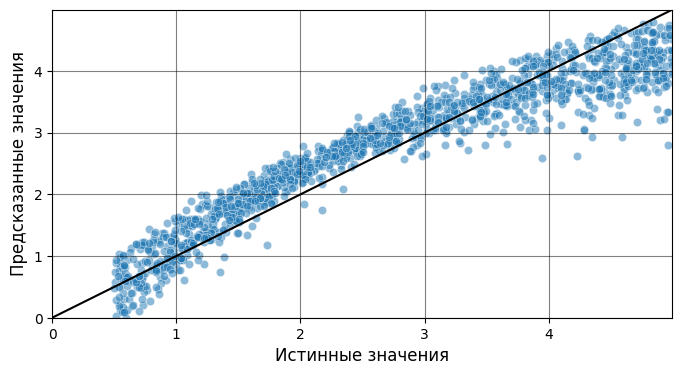

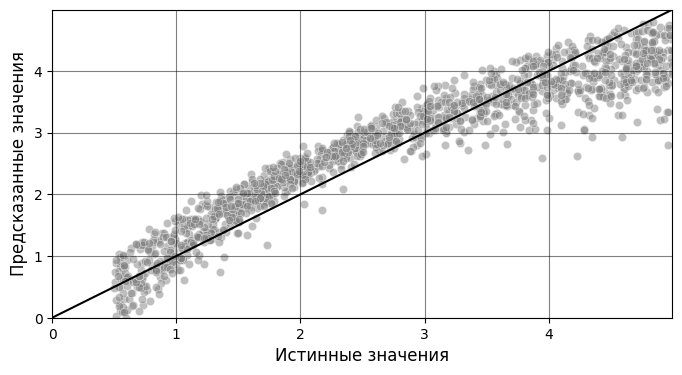

In [27]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/Untitled Folder/gamma_alpha")

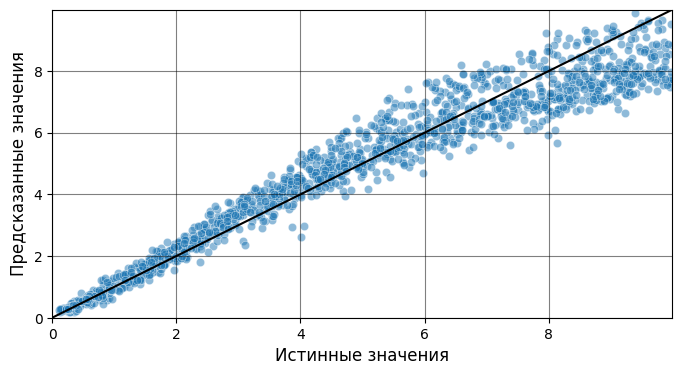

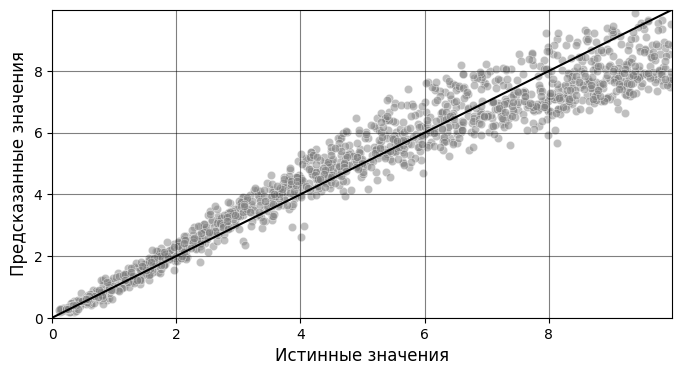

In [28]:
scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/Untitled Folder/gamma_beta")

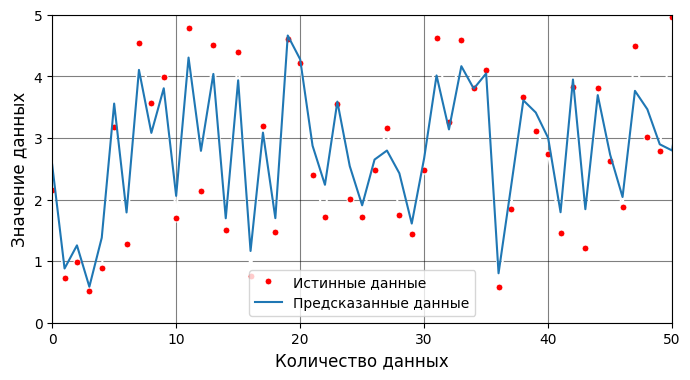

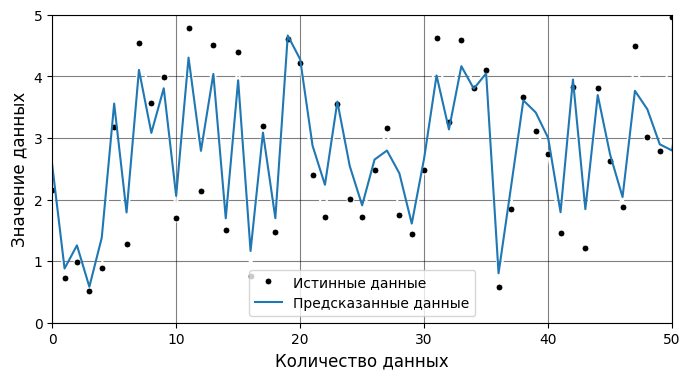

In [29]:
line_plot(test_intervals_Y[:,0], pred[:,0], 50, "/home/jupyter/datasphere/project/Untitled Folder/gamma_line_alpha")

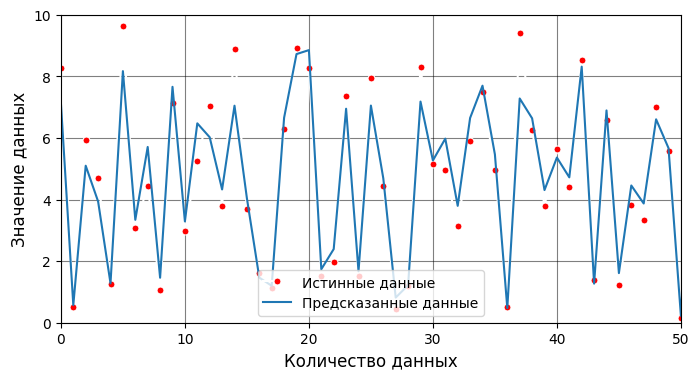

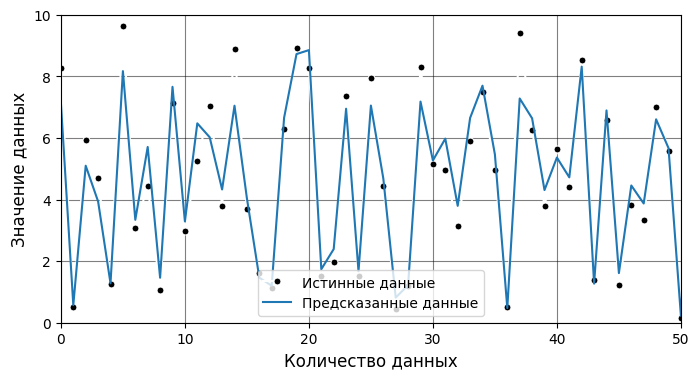

In [30]:
line_plot(test_intervals_Y[:,1], pred[:,1], 50, "/home/jupyter/datasphere/project/Untitled Folder/gamma_line_beta")

In [31]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/catboost_info/test_error.tsv', sep='\t', index_col=0)

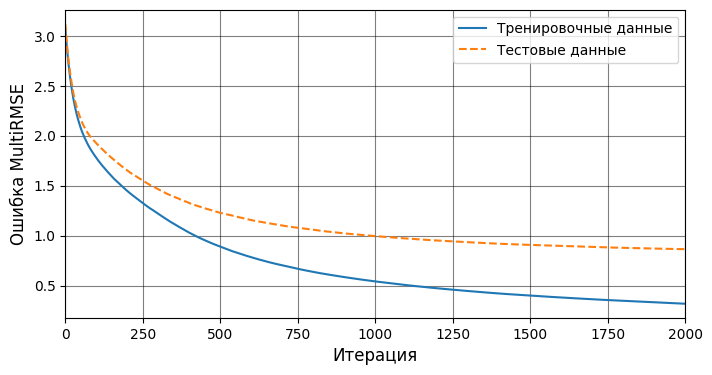

In [38]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, 2000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/catboost_train_colored.pdf', bbox_inches="tight")

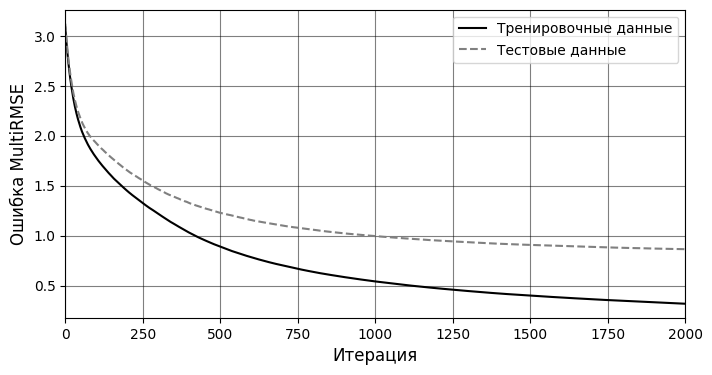

In [39]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, 2000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/catboost_train.pdf', bbox_inches="tight")

## Catboost статистика

In [14]:
train_stat_M = calculate_statistics(train_intervals_X)
test_stat_M = calculate_statistics(test_intervals_X)
val_stat_M = calculate_statistics(val_intervals_X)

In [20]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 1000,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 1000,
    #"early_stopping_rounds": 1000,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.003
}

gamma_stat = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
gamma_stat.fit(train_stat_M, train_intervals_Y, eval_set=(val_stat_M, val_intervals_Y), use_best_model=True)

0:	learn: 1.7727382	test: 1.7706751	best: 1.7706751 (0)	total: 4.77ms	remaining: 4.77s
999:	learn: 0.0489540	test: 0.0561418	best: 0.0561418 (999)	total: 2.3s	remaining: 0us

bestTest = 0.05614177524
bestIteration = 999



In [25]:
pred = gamma_stat.predict(test_stat_M)

In [24]:
gamma_stat.save_model("lognorm3")

### Метрики

In [35]:
# Оценка качества для первого параметра
evaluate_regression(test_intervals_Y[:, 0], pred[:, 0], "alpha_value")

# Оценка качества для второго параметра
evaluate_regression(test_intervals_Y[:, 1], pred[:, 1], "beta_value")


alpha_value
MAE: 0.024
MSE: 0.001
RMSE: 0.034
MAPE: 7.388%
R² Score: 0.999

beta_value
MAE: 0.024
MSE: 0.001
RMSE: 0.032
MAPE: 1.183%
R² Score: 0.999


In [26]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=SEED, shuffle=True)
test_df, val_df = train_test_split(test_df, train_size=0.7, random_state=SEED, shuffle=True)

test_df_X = np.array(test_df)[:, :10000]
test_df_Y = np.array(test_df)[:, 10000:10002]

test_df_gen = gen_recurr(test_df_X.shape[0], test_df_X.shape[1], pred[:,0], pred[:,1])

test_interval_df_gen = get_intervals_from_df(test_df_gen.iloc[:, :10000])

In [27]:
a = test_df_X[0:test_df_X.shape[0], :test_df_X.shape[1]]
b = np.array(test_df_gen.iloc[0:test_df_X.shape[0], :test_df_X.shape[1]])

itog_itog_list = []

for i in range(test_df_X.shape[0]):
    itog_list = []
    n_cols = test_df_X.shape[1] # Store this value to avoid repeated access

    if np.max(a[i]) > np.max(b[i]): # Use NumPy's max for efficiency
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))
    else:
        counter1 = 0
        counter2 = 0
        while counter1 < n_cols and counter2 < n_cols: #Ensure no index errors
            diff = counter1 - counter2
            if a[i][counter1] < b[i][counter2]:
                counter1 += 1
            elif a[i][counter1] > b[i][counter2]:
                counter2 += 1
            else:
                counter1 += 1
                counter2 += 1
            itog_list.append(abs(diff))

    itog_itog_list.append(itog_list)

In [38]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	9.008
relative_error_mean_median:	0.737
relative_error_std_mean:	13.387
relative_error_std_median:	0.950
abs_mean:	5093.792
abs_median:	5190.500


In [28]:
print_curve_metrics(test_intervals_df.iloc[:, :9999], test_interval_df_gen, itog_itog_list)

relative_error_mean_mean:	14.818
relative_error_mean_median:	0.701
relative_error_std_mean:	38.737
relative_error_std_median:	0.888
abs_mean:	5137.792
abs_median:	5323.500


### Рисунки

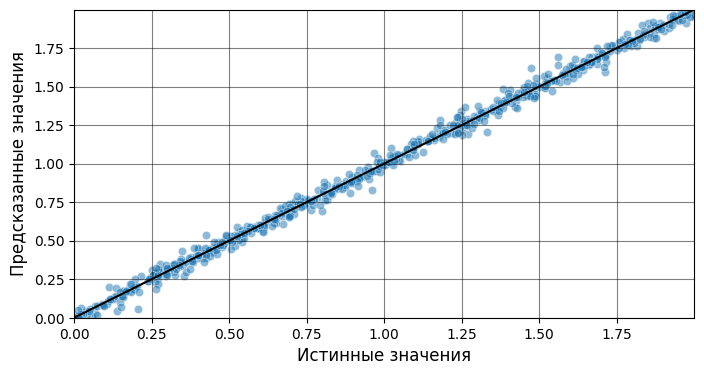

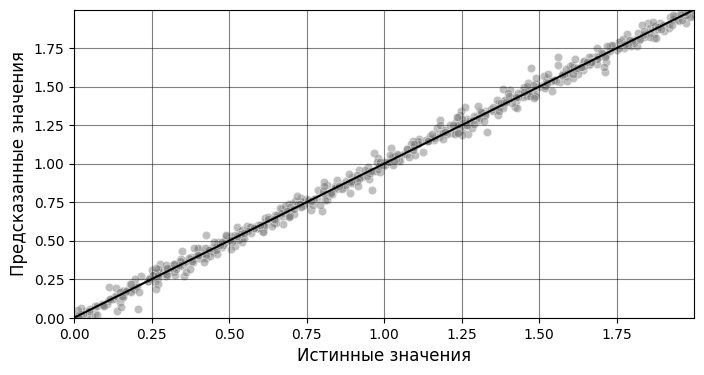

In [56]:
scatter_plot(test_intervals_Y[:,0], pred[:,0], max(test_intervals_Y[:,0]), "/home/jupyter/datasphere/project/Untitled Folder/lognorm_1")

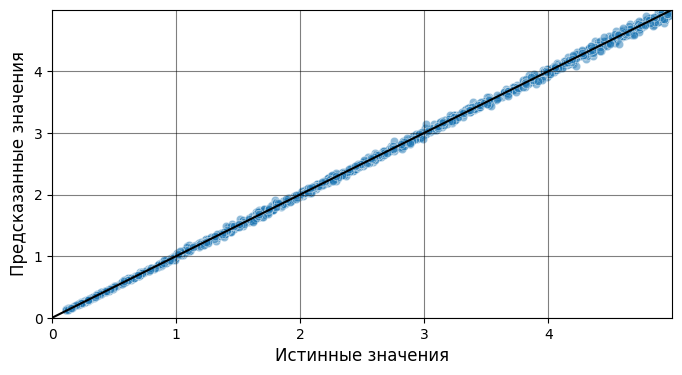

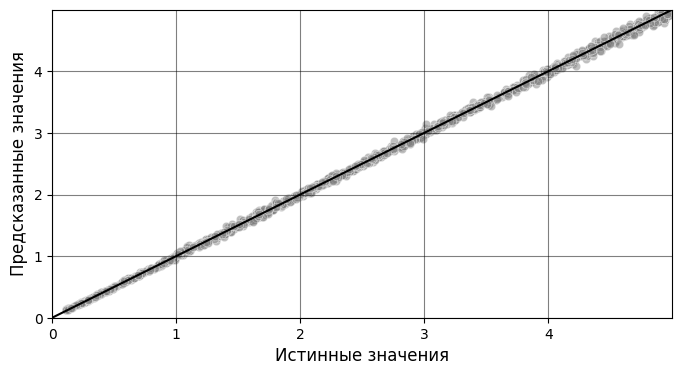

In [57]:
scatter_plot(test_intervals_Y[:,1], pred[:,1], max(test_intervals_Y[:,1]), "/home/jupyter/datasphere/project/Untitled Folder/lognorm_2")

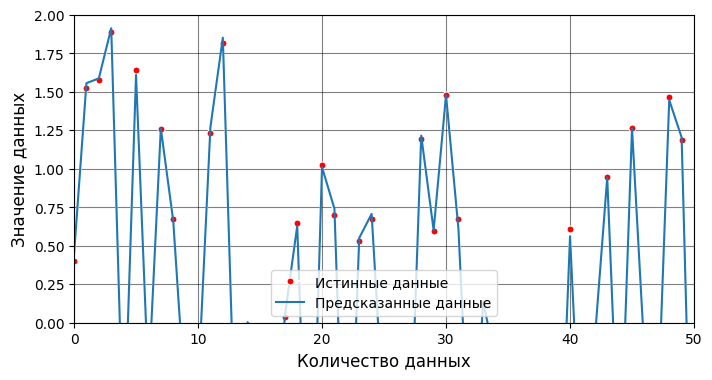

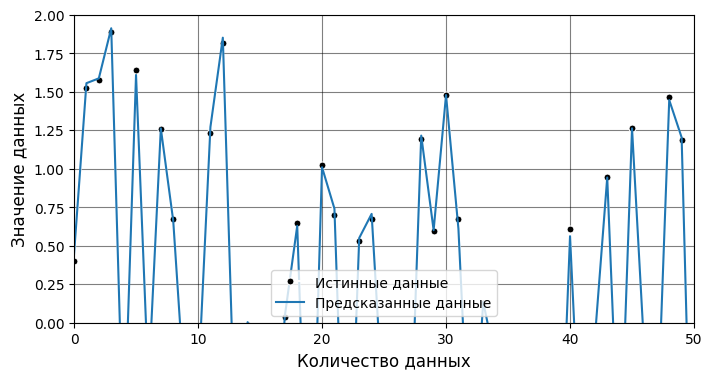

In [58]:
line_plot(test_intervals_Y[:,0], pred[:,0], 50, "/home/jupyter/datasphere/project/Untitled Folder/lognorm_1_line")

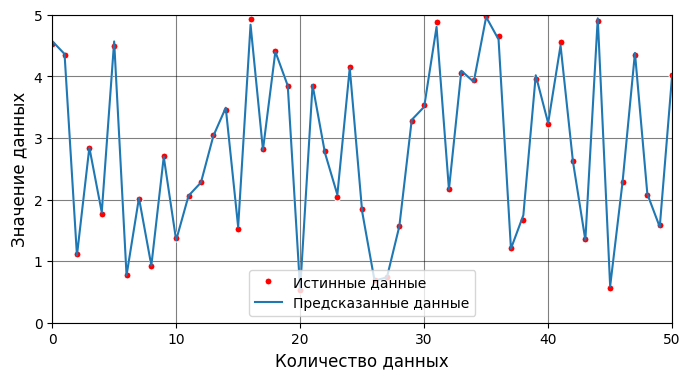

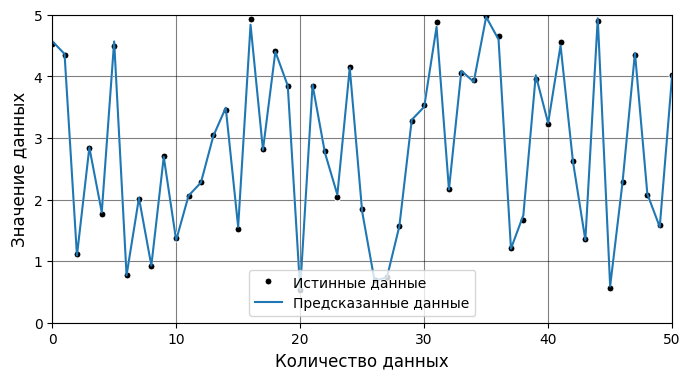

In [59]:
line_plot(test_intervals_Y[:,1], pred[:,1], 50, "/home/jupyter/datasphere/project/Untitled Folder/lognorm_3_line")

In [61]:
learn_error_df = pd.read_csv('/home/jupyter/datasphere/project/catboost_info/learn_error.tsv', sep='\t', index_col=0)
test_error_df = pd.read_csv('/home/jupyter/datasphere/project/catboost_info/test_error.tsv', sep='\t', index_col=0)

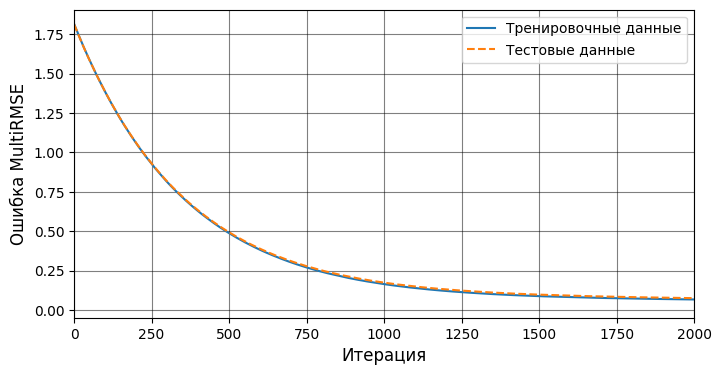

In [62]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', linestyle='--')  # Simplified
plt.xlim(0, 2000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/catboost_train_colored.pdf', bbox_inches="tight")

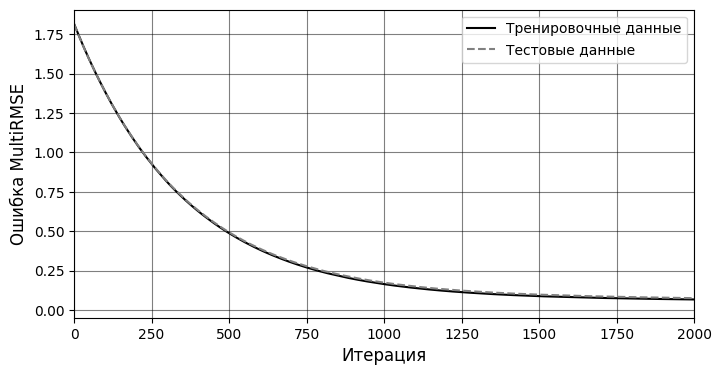

In [63]:
plt.figure(figsize=(8, 4))  # Create separate figures
sns.lineplot(np.array([list(row) for _, row in learn_error_df.iterrows()]).flatten().tolist(), label='Тренировочные данные', color='black')
sns.lineplot(np.array([list(row) for _, row in test_error_df.iterrows()]).flatten().tolist(), label='Тестовые данные', color='gray', linestyle='--')  # Simplified
plt.xlim(0, 2000)
plt.xlabel('Итерация', fontsize=12)
plt.ylabel('Ошибка MultiRMSE', fontsize=12)
plt.grid(alpha=0.5, color='black')
plt.savefig('/home/jupyter/datasphere/project/catboost_train.pdf', bbox_inches="tight")

## Catboost моменты

In [45]:
train_X = np.array(train_df)[:, :10000]
train_Y = np.array(train_df)[:, 10000:]
test_X = np.array(test_df)[:, :10000]
test_Y = np.array(test_df)[:, 10000:]
val_X = np.array(val_df)[:, :10000]
val_Y = np.array(val_df)[:, 10000:]

In [46]:
params = {
    "loss_function": "MultiRMSE",
    "verbose": 100,
    "random_seed": SEED,
    #"task_type": "GPU",  # Уберите, если у вас нет GPU
    "iterations": 2000,
    "early_stopping_rounds": 200,
    #"l2_leaf_reg": 3,
    #"depth": 8,
    #"learning_rate": 0.03
}

gamma_moments = CatBoostRegressor(**params)

# Обучение с использованием валидационной выборки
gamma_moments.fit(train_X, train_Y, eval_set=(val_X, val_Y), use_best_model=True)

0:	learn: 1.9939744	test: 2.0285372	best: 2.0285372 (0)	total: 1.18s	remaining: 39m 9s
100:	learn: 0.9743154	test: 0.9660053	best: 0.9660053 (100)	total: 56.3s	remaining: 17m 39s
200:	learn: 0.8993546	test: 0.9012230	best: 0.9012230 (200)	total: 1m 56s	remaining: 17m 22s
300:	learn: 0.8575762	test: 0.8764056	best: 0.8764056 (300)	total: 3m 3s	remaining: 17m 13s
400:	learn: 0.8120724	test: 0.8540444	best: 0.8540444 (400)	total: 4m 10s	remaining: 16m 38s
500:	learn: 0.7729894	test: 0.8348926	best: 0.8348926 (500)	total: 5m 11s	remaining: 15m 32s
600:	learn: 0.7412120	test: 0.8192992	best: 0.8192992 (600)	total: 6m 7s	remaining: 14m 16s
700:	learn: 0.7154433	test: 0.8114697	best: 0.8114140 (697)	total: 7m 1s	remaining: 13m
800:	learn: 0.6931300	test: 0.8052602	best: 0.8052164 (798)	total: 7m 53s	remaining: 11m 48s
900:	learn: 0.6711266	test: 0.7979687	best: 0.7979687 (900)	total: 8m 45s	remaining: 10m 41s
1000:	learn: 0.6521352	test: 0.7927408	best: 0.7927408 (1000)	total: 9m 39s	remainin

In [49]:
pred = gamma_moments.predict(test_X)

In [50]:
# Оценка качества для первого параметра
evaluate_regression(test_Y[:, 0], pred[:, 0], "alpha_value")

# Оценка качества для второго параметра
evaluate_regression(test_Y[:, 1], pred[:, 1], "beta_value")


alpha_value
MAE: 0.481
MSE: 0.407
RMSE: 0.638
MAPE: 164.918%
R² Score: 0.694

beta_value
MAE: 0.247
MSE: 0.094
RMSE: 0.306
MAPE: 18.482%
R² Score: 0.954
